<a href="https://colab.research.google.com/github/Caculuz-cinks/black_faces_age_estimation/blob/main/FGNet_Age_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import os
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dataset_path = '/content/drive/My Drive/FGNET/images'

In [18]:
import os
import cv2
import numpy as np
import re
from sklearn.model_selection import train_test_split

# Prepare empty arrays to hold images and labels
images = []
ages = []

# Path to your dataset
dataset_path = '/content/drive/My Drive/FGNET/images'  # Update this to your dataset path

# Regular expression pattern to extract the age from filenames
pattern = re.compile(r'(\d{2})\.JPG$')

# Load the images and corresponding age labels from the dataset
for img_file in os.listdir(dataset_path):
    if img_file.endswith(".JPG"):  # Adjust this if images are in another format
        # Load the image
        img = cv2.imread(os.path.join(dataset_path, img_file))
        if img is not None:
            img = cv2.resize(img, (128, 128))  # Resize to uniform size

            # Extract age from the filename using regex
            match = pattern.search(img_file)
            if match:
                age = int(match.group(1))  # Extracted age
                images.append(img)
                ages.append(age)
            else:
                print(f"Warning: Filename '{img_file}' does not match expected format.")
        else:
            print(f"Warning: Could not load image '{img_file}'.")

# Convert lists to numpy arrays
images = np.array(images)
ages = np.array(ages, dtype=np.float32)  # Convert ages to float32 for regression

# Print lengths to debug
print(f"Number of images: {len(images)}")
print(f"Number of ages: {len(ages)}")

# Ensure images and ages have the same length
if len(images) != len(ages):
    raise ValueError("Number of images and ages do not match.")

# Normalize images
images = images / 255.0  # Normalize pixel values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, ages, test_size=0.2, random_state=42)


Number of images: 974
Number of ages: 974


In [19]:
# Import necessary modules
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

# Load ResNet50 pre-trained model without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers for regression
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)  # Add dropout to avoid overfitting
x = Dense(64, activation='relu')(x)
predictions = Dense(1)(x)  # Output layer for age regression

# Combine base model and custom layers into a new model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the ResNet50 layers (optional: you can fine-tune later)
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Print the model summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,858,305 (91.01 MB)

 Trainable params: 270,593 (1.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [21]:
import numpy as np
import cv2
import os
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam


datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Load ResNet50 pre-trained model without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Add custom layers for regression
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)  # Add dropout to avoid overfitting
x = Dense(64, activation='relu')(x)
predictions = Dense(1)(x)  # Output layer for age regression

# Combine base model and custom layers into a new model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the ResNet50 layers (optional: you can fine-tune later)
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mae'])

# Print model summary
model.summary()

# Train the model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) // 32,
    epochs=20
)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 134, 134, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 64, 64, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 64, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 64, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 66, 66, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 32, 32, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 32, 32, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 32, 32, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 32, 32, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 32, 32, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,858,305 (91.01 MB)

 Trainable params: 270,593 (1.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 29s 626ms/step - loss: 305.2711 - mae: 12.9137 - val_loss: 183.8086 - val_mae: 10.8810
Epoch 2/20
 1/24 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 202.3753 - mae: 11.3708

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 202.3753 - mae: 11.3708 - val_loss: 184.5907 - val_mae: 10.9792
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - loss: 167.3307 - mae: 10.1485 - val_loss: 186.1215 - val_mae: 10.5566
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 187.2620 - mae: 10.7474 - val_loss: 185.7704 - val_mae: 10.5664
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - loss: 138.2278 - mae: 9.2286 - val_loss: 185.4717 - val_mae: 10.5736
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 242.0163 - mae: 11.0599 - val_loss: 185.1062 - val_mae: 10.5864
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - loss: 167.1192 - mae: 9.8820 - val_loss: 188.0055 - val_mae: 10.5107
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 331.0803 - mae: 13.6601 - val_loss: 187.4731 - val_mae: 10.5203
Epoch 9/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - loss: 154.7583 - mae: 9.5389 - val_loss: 184.7711 - val_mae: 10.5900
Epoch 10/20
24/24 ━━━━━━━━━━

In [22]:
# Unfreeze all layers in the ResNet50 model
for layer in base_model.layers:
    layer.trainable = True

# Compile the model again with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='mean_squared_error', metrics=['mae'])

# Fine-tune the model
history_fine = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=10
)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - loss: 180.6882 - mae: 9.6978 - val_loss: 196.7706 - val_mae: 10.4469
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - loss: 150.7907 - mae: 8.6341 - val_loss: 195.5236 - val_mae: 10.4447
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - loss: 111.1238 - mae: 7.4657 - val_loss: 191.8416 - val_mae: 10.4788
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 195ms/step - loss: 84.3788 - mae: 6.4732 - val_loss: 189.3006 - val_mae: 11.2500
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - loss: 73.7550 - mae: 6.5056 - val_loss: 210.0529 - val_mae: 12.4217
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/step - loss: 78.9941 - mae: 6.5484 - val_loss: 226.7092 - val_mae: 13.0743
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - loss: 58.5369 - mae: 5.8234 - val_loss: 236.2157 - val_mae: 13.3730
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 166ms/step - loss: 52.0450 - mae: 5.4053 - val_loss: 314.4789 - val_mae: 15.6772
Epoch 9/10
25/25 ━━━━━━

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 502.4102 - mae: 19.8095
Test MAE: 20.239099502563477


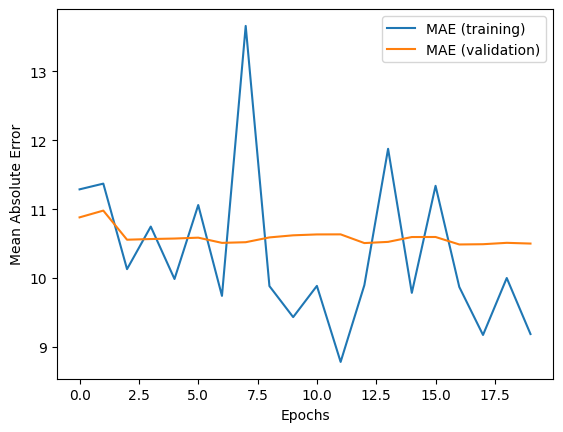

In [23]:
# Evaluate the model on test data
test_loss, test_mae = model.evaluate(X_test, y_test)

print(f"Test MAE: {test_mae}")

# Plot training history
plt.plot(history.history['mae'], label='MAE (training)')
plt.plot(history.history['val_mae'], label='MAE (validation)')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

In [24]:
# Save the trained model
model.save('age_estimation_resnet50_fgnet_model.h5')

In [25]:
from tensorflow.keras.models import load_model

model = load_model('age_estimation_resnet50_fgnet_model.h5')

In [27]:
from google.colab import files

# Upload an image
uploaded = files.upload()

# Get the filename of the uploaded image
filenames = list(uploaded.keys())
print(f"Uploaded file: {filenames}")

Saving 001A02.JPG to 001A02.JPG
Saving 001A12.JPG to 001A12.JPG
Saving 001A22.JPG to 001A22.JPG
Saving 001A28.JPG to 001A28.JPG
Saving 001A53.JPG to 001A53.JPG
Saving 001A80.JPG to 001A80.JPG
Uploaded file: ['001A02.JPG', '001A12.JPG', '001A22.JPG', '001A28.JPG', '001A53.JPG', '001A80.JPG']


In [28]:
from tensorflow.keras.preprocessing import image
import numpy as np

img = image.load_img('/content/001A02.JPG',
target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.
batch_size=32,  # Rescale like during training

In [32]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import re

def show_prediction(fname, model):
    # Extract the age from the filename
    match = re.search(r'(\d{2})\.JPG$', fname)
    if not match:
        print("Filename format is incorrect. Unable to extract age.")
        return

    real_age = int(match.group(1))

    # Load and preprocess the image
    img = image.load_img(fname, target_size=(128, 128))  # Match target_size to model input size
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.  # Rescale like during training

    # Make the prediction
    prediction = model.predict(img_array)
    pred = round(prediction[0][0])

    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()

    # Print the predicted and actual age
    print(f"Predicted Age: {pred} | Actual Age: {real_age}")

# Example usage



1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


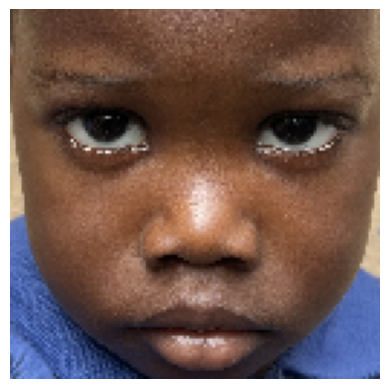

Predicted Age: 34 | Actual Age: 2


In [34]:
# show_prediction('/content/001A02.JPG', 2)
show_prediction('/content/001A02.JPG', model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


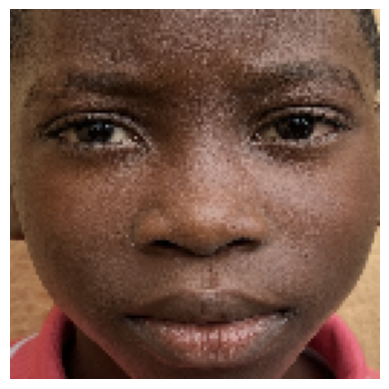

Predicted Age: 41 | Actual Age: 12


In [35]:
show_prediction('/content/001A12.JPG', model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


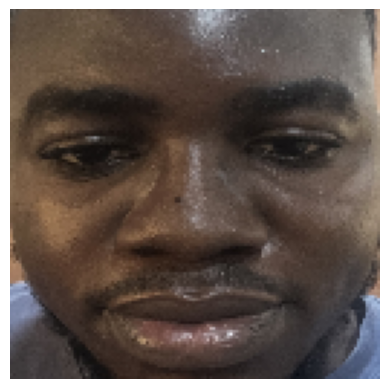

Predicted Age: 41 | Actual Age: 22


In [36]:
show_prediction('/content/001A22.JPG', model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


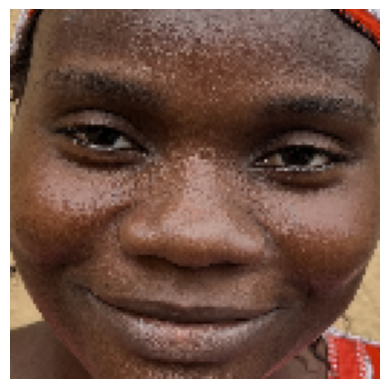

Predicted Age: 37 | Actual Age: 28


In [37]:
show_prediction('/content/001A28.JPG', model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


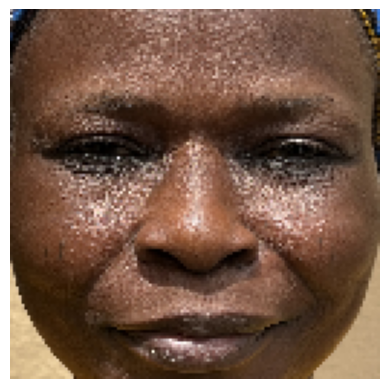

Predicted Age: 37 | Actual Age: 53


In [38]:
show_prediction('/content/001A53.JPG', model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


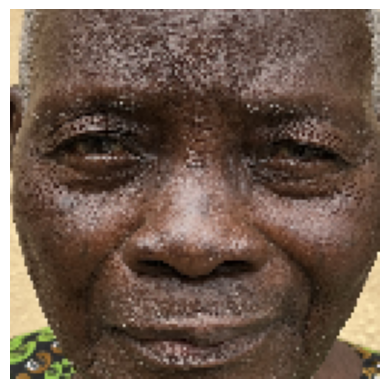

Predicted Age: 36 | Actual Age: 80


In [39]:
show_prediction('/content/001A80.JPG', model)